## CA 3, LLMs Spring 2024

- **Name:** Majid Faridfar
- **Student ID:** 810199569

---

# PEFT (30 + 5 points)

## Why We Are Using PEFT (5 points)

In this question, we're delving into PEFT. First, let's start by exploring why PEFT is crucial when training LLMs. For instance, let's consider the scenario where we want to train the [microsoft/phi-2](https://huggingface.co/microsoft/phi-2) model. To get started, take a look at the Huggingface blog post on [model memory anatomy](https://huggingface.co/docs/transformers/en/model_memory_anatomy) to estimate how much memory we'll require. Just assume we're sticking to pure fp16 with Adam optimizer and a batch size of 1. (4 points)

> Provided in Model Summary of microsoft/phi-2 in HuggingFace:
> > Phi-2 is a Transformer with 2.7 billion parameters.
>
> So we have:
>
> - Model weights: 4 * 2.7B / 2 = 5.4 GB
>
> - Optimizer States: 8 * 2.7B / 2 = 10.8 GB (for normal AdamW)
>
> - Gradients: 4 * 2.7B = 10.8 GB (gradients are always kept in fp32)
>
> Also we ignore Forward Activations, Temporary Memory and Functionality-specific memory, as they are not easily calculatable.
>
> So the required memory amount is: 5.4 GB + 10.8 GB + 10.8 GB = 27 GB

Compare your estimation with the memory estimation provided by the [Model Memory Calculator](https://huggingface.co/spaces/hf-accelerate/model-memory-usage). (1 point)

> 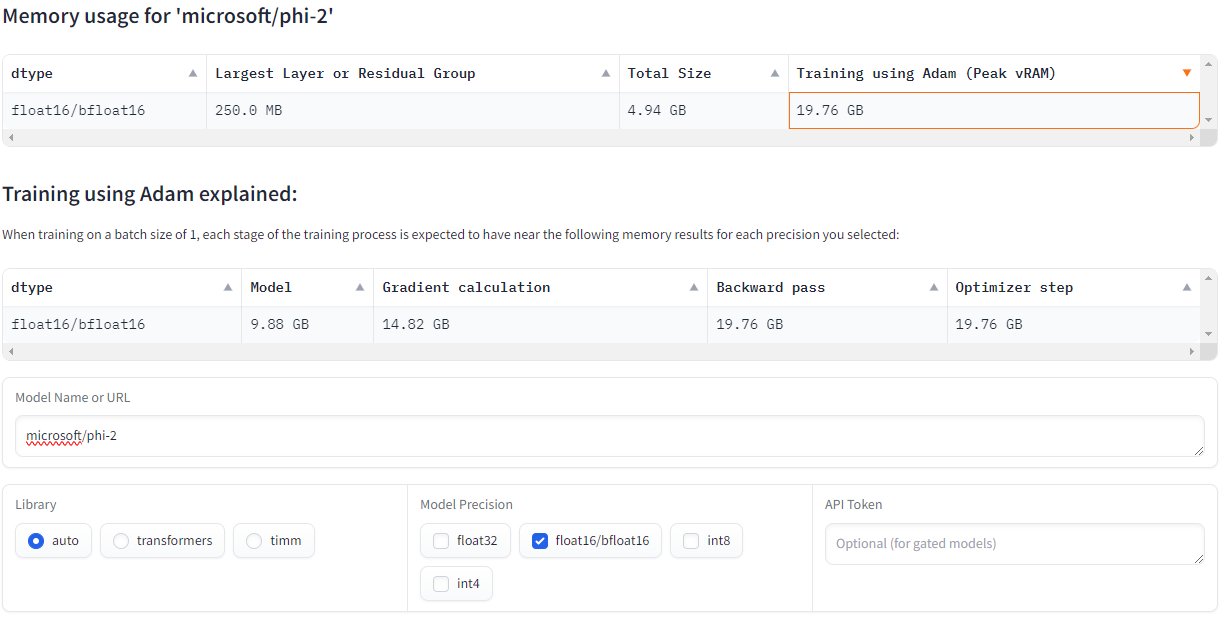
>
> As you can see, the real required amount of memory (19.76 GB) for fp16 is less than estimated one (27 GB), which is due to some optimizations.

## Preparing Dataset (5 points)

We're going to train the phi-2 model for a question generation task based on passages. For this purpose, we're using the Super-NaturalInstruction dataset, which comprises instruction tuning datasets for over 1600 tasks across different languages. While the dataset is available on the [Huggingface Hub](https://huggingface.co/datasets/Muennighoff/natural-instructions), downloading all its components consumes considerable time. Consequently, we're opting to download only the English Question Generation segment.

In [ ]:
!wget https://huggingface.co/datasets/Muennighoff/natural-instructions/resolve/main/train/task001_quoref_question_generation_train.jsonl

--2024-05-16 02:21:05--  https://huggingface.co/datasets/Muennighoff/natural-instructions/resolve/main/train/task001_quoref_question_generation_train.jsonl
Resolving huggingface.co (huggingface.co)... 18.172.134.24, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/a1/fe/a1fedd93d2c00f67a096c36747356c03b6f01649bae4b4be932e6531a496022a/89ad3018bdb2cec45afea661fbe2fc8df9593243f58531d381c19b5fb13ce581?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27task001_quoref_question_generation_train.jsonl%3B+filename%3D%22task001_quoref_question_generation_train.jsonl%22%3B&Expires=1716085265&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjA4NTI2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9hMS9mZS9hMWZlZGQ5M2QyYzAwZjY3YTA5NmMzNjc0NzM1NmMwM2I2ZjAxNjQ5YmFlN

Read the dataset file and convert it into a `dataset` object. Then, split the dataset, selecting 95% for the training set and 5% for the test set. (5 points)

In [ ]:
# WRITE YOUR CODE HERE

from datasets import load_dataset

dataset = load_dataset('json', data_files='task001_quoref_question_generation_train.jsonl', split='train')

dataset_train_test = dataset.train_test_split(test_size=0.05, shuffle=True, seed=42)
# dataset_train_test = dataset.train_test_split(test_size=0.05, shuffle=False, seed=42) # Debug

train_dataset = dataset_train_test['train']
test_dataset = dataset_train_test['test']

Generating train split: 0 examples [00:00, ? examples/s]

## Pretrained Model (5 points)

Choose random samples from the test set, apply the [Alpaca template](https://github.com/tatsu-lab/stanford_alpaca?tab=readme-ov-file#data-release) to them, and obtain the model outputs (If you are using the [sample code](https://huggingface.co/microsoft/phi-2#sample-code) provided by Microsoft for using the model, please comment out the `torch.set_default_device("cuda")` line to conserve memory. Instead, you can move the model to the GPU using the `.to` function after loading it.). (5 points)

In [ ]:
device = 'cuda'

In [ ]:
# # WRITE YOUR CODE HERE

import torch
from transformers import AutoModelForCausalLM

torch.set_default_device(device)

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype=torch.float32, device_map="cpu", trust_remote_code=True) # Debug

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [ ]:
import torch
from transformers import AutoTokenizer

torch.set_default_device(device)

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
NUM_OF_TEST_SAMPLES = 5

shuffled_test_dataset = test_dataset.shuffle(seed=42) # Comment to debug and replace shuffled_test_dataset with test_dataset in the next line
sampled_test_dataset = shuffled_test_dataset.select(range(NUM_OF_TEST_SAMPLES))

In [ ]:
i = 1
for row in sampled_test_dataset:
    instruction = row['definition']
    input = row['inputs']

    alpaca_templated = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:"""

    inputs = tokenizer(alpaca_templated, return_tensors="pt", return_attention_mask=False)

    inputs.to(device)

    outputs = model.generate(**inputs, max_length=2048)
    text = tokenizer.batch_decode(outputs)[0]

    print(f"**Sample {i}**\n")
    print(f"**Definition**\n{row['definition']}\n")
    print(f"**Input**\n{row['inputs']}\n")
    print(f"**Output**\n{text}\n")
    print("--------------------------------")

    i += 1

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Sample 1**

**Definition**
In this task, you're given passages that contain mentions of names of people, places, or things. Some of these mentions refer to the same person, place, or thing. Your job is to write questions that evaluate one's understanding of such references. Good questions are expected to link pronouns (she, her, him, his, their, etc.) or other mentions to people, places, or things to which they may refer. Do not ask questions that can be answered correctly without understanding the paragraph or having multiple answers. Avoid questions that do not link phrases referring to the same entity. For each of your questions, the answer should be one or more phrases in the paragraph, and it should be unambiguous.

**Input**
Passage: Following the accession of James VII in 1685, Bruce gradually fell from favour, and was distrusted by the new regime. After the Revolution of 1688, and the accession of William of Orange as King, he was once again at odds with his Protestant rulers

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Sample 2**

**Definition**
In this task, you're given passages that contain mentions of names of people, places, or things. Some of these mentions refer to the same person, place, or thing. Your job is to write questions that evaluate one's understanding of such references. Good questions are expected to link pronouns (she, her, him, his, their, etc.) or other mentions to people, places, or things to which they may refer. Do not ask questions that can be answered correctly without understanding the paragraph or having multiple answers. Avoid questions that do not link phrases referring to the same entity. For each of your questions, the answer should be one or more phrases in the paragraph, and it should be unambiguous.

**Input**
Passage: The Swimming Hole (also known as Swimming and The Old Swimming Hole) is an 1884–85 painting by the American artist Thomas Eakins (1844–1916), Goodrich catalog #190, in the collection of the Amon Carter Museum of American Art in Fort Worth, Texas. E

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Sample 3**

**Definition**
In this task, you're given passages that contain mentions of names of people, places, or things. Some of these mentions refer to the same person, place, or thing. Your job is to write questions that evaluate one's understanding of such references. Good questions are expected to link pronouns (she, her, him, his, their, etc.) or other mentions to people, places, or things to which they may refer. Do not ask questions that can be answered correctly without understanding the paragraph or having multiple answers. Avoid questions that do not link phrases referring to the same entity. For each of your questions, the answer should be one or more phrases in the paragraph, and it should be unambiguous.

**Input**
Passage: The Mozart children were not alone as 18th-century music prodigies. Education writer Gary Spruce refers to hundreds of similar cases, and cites that of William Crotch of Norwich who in 1778, at the age of three, was giving organ recitals. British s

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**Sample 4**

**Definition**
In this task, you're given passages that contain mentions of names of people, places, or things. Some of these mentions refer to the same person, place, or thing. Your job is to write questions that evaluate one's understanding of such references. Good questions are expected to link pronouns (she, her, him, his, their, etc.) or other mentions to people, places, or things to which they may refer. Do not ask questions that can be answered correctly without understanding the paragraph or having multiple answers. Avoid questions that do not link phrases referring to the same entity. For each of your questions, the answer should be one or more phrases in the paragraph, and it should be unambiguous.

**Input**
Passage: Thompson currently lives in Amherst, Massachusetts, and is married to Violet Clark, his second wife, with whom he has three children, along with her two children from previous relationships. The couple formerly lived in Eugene, Oregon, where they m

## Fine-tuning with LoRA (15 + 5 points)

In [ ]:
# !pip install trl peft
!pip install -qU trl peft accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 34.7 MB/s eta 0:00:00


In this phase, we're fine-tuning the phi-2 model on a question generation dataset. To begin, we need to format our dataset into the instruction tuning format. For this task, we can employ `DataCollatorForCompletionOnlyLM`. Look at the [example](https://huggingface.co/docs/trl/en/sft_trainer#train-on-completions-only) in the HuggingFace documentation and instantiate the data collator using the Alpaca template. (3 points)

In [ ]:
device = "cuda"

In [ ]:
import torch
from transformers import AutoTokenizer

torch.set_default_device(device)

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# WRITE YOUR CODE HERE

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['definition'])):
        text = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{example['definition'][i]}

### Input:
{example['inputs'][i]}

### Response:
{example['targets'][i]}"""
        output_texts.append(text)
    return output_texts

instruction_template = "### Instruction:"
response_template = " ### Response:"

collator = DataCollatorForCompletionOnlyLM(instruction_template=instruction_template, response_template=response_template, tokenizer=tokenizer)

Refer to the HuggingFace [documentation](https://huggingface.co/docs/trl/en/sft_trainer#training-adapters) and instantiate the Lora config. (3 points)

In [ ]:
# WRITE YOUR CODE HERE

from peft import LoraConfig

peft_config = LoraConfig(
    r=2,
    lora_alpha=10,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

Configure other training arguments. [Here](https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/trainer#transformers.TrainingArguments) is a list of available options. Consider using a small batch size to prevent CUDA out of memory errors. You can augment batch size artificially through gradient accumulation. Enabling gradient checkpointing can further save memory. You may train the model for tens of steps. (3 points)

In [ ]:
# WRITE YOUR CODE HERE

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    auto_find_batch_size=True,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    save_total_limit=0,
)

Take a look at the HuggingFace [documentation](https://huggingface.co/docs/trl/en/sft_trainer) on supervised fine-tuning trainers. Instantiate the trainer and train the model ( Note that you should initialize the phi-2 model with `bfloat16` or `float16` dtype to avoid encountering Cuda out of memory errors.). (3 points)

In [ ]:
# WRITE YOUR CODE HERE

import torch
from transformers import AutoModelForCausalLM#, AutoTokenizer

torch.set_default_device(device)

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype=torch.float16, trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype=torch.float32, device_map="cpu", trust_remote_code=True)

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [ ]:
NUM_OF_TRAIN_SAMPLES = 200

shuffled_train_dataset = train_dataset.shuffle(seed=42)
sampled_train_dataset = shuffled_train_dataset.select(range(NUM_OF_TRAIN_SAMPLES))

In [ ]:
trainer = SFTTrainer(
    model,
    train_dataset=sampled_train_dataset,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_args,
)

trainer.train()

Get the final model from the trainer and merge the Lora weights with it. Then, test the model with the inputs you gave to the pretrained model and compare the results. (3 points)

In [ ]:
# WRITE YOUR CODE HERE

model = trainer.model.merge_and_unload()

i = 1
for row in sampled_test_dataset:
    instruction = row['definition']
    input = row['inputs']

    alpaca_templated = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Input:
{input}

### Response:"""

    inputs = tokenizer(alpaca_templated, return_tensors="pt", return_attention_mask=False)

    inputs.to(device)

    outputs = model.generate(**inputs, max_length=2048)
    text = tokenizer.batch_decode(outputs)[0]

    print(f"**Sample {i}**\n")
    print(f"**Definition**\n{row['definition']}\n")
    print(f"**Input**\n{row['inputs']}\n")
    print(f"**Output**\n{text}\n")
    print("--------------------------------")

    i += 1

> Since running these cell is so much time-consuming or to reduce its run time we need to reduce the number of samples which results in a poor performance, I avoided running the last two cells and just wrote the codes (Obviously since I hadn't the results of fine-tuned model, I couldn't compare them in the last cell of this section).
>
> Techincally the fine-tuned model should generate better responses rather than pure pretrained model since it has seen more related shots.

We know that fine-tuning LLMs on Colab or Kaggle notebooks can be a bit tricky, and fine-tuning phi-2 for this task may require more GPU hours. The main point of this question is to teach you how to train your model using HuggingFace packages. So, it's okay if your model doesn't produce optimal results. However, there are 5 additional points available if it can generate better results :)